# Day 22

In [1]:
from aocd import get_data
from inspect import cleandoc
from IPython.display import display, Markdown

def answer(x):
    display(Markdown(f"**Answer** = {x}"))

data = get_data(year=2023, day=22)

## Part 1

In [2]:
example = cleandoc("""
    1,0,1~1,2,1
    0,0,2~2,0,2
    0,2,3~2,2,3
    0,0,4~0,2,4
    2,0,5~2,2,5
    0,1,6~2,1,6
    1,1,8~1,1,9
""")

In [3]:
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum
from functools import cached_property
from itertools import product
from more_itertools import first, ilen
import igraph

@dataclass(frozen=True)
class Point:
    cs: tuple

    def __init__(self, *cs):
        if len(cs) == 1:
            object.__setattr__(self, "cs", tuple(cs[0]))
        else:
            object.__setattr__(self, "cs", tuple(cs))

    @classmethod
    def parse(cls, text):
        return cls(map(int, text.split(",")))

    def __getitem__(self, k):
        return self.cs[k]

    def __iter__(self):
        return iter(self.cs)

    def __add__(self, other):
        return Point(c1 + c2 for c1, c2 in zip(self.cs, other.cs))

    def __mul__(self, k):
        return Point(c * k for c in self.cs)

    __rmul__ = __mul__

    def __repr__(self):
        return f"{self.__class__.__name__}({", ".join(map(str, self.cs))})"

class Direction3d(Point, Enum):
    U = (0, 0, 1)
    D = (0, 0, -1)
    F = (0, 1, 0)
    B = (0, -1, 0)
    R = (1, 0, 0)
    L = (-1, 0, 0)

@dataclass
class Brick:
    p1: Point
    p2: Point

    @classmethod
    def parse(cls, text):
        return cls(*map(Point.parse, text.split("~")))

    def __add__(self, p: Point):
        return Brick(self.p1 + p, self.p2 + p)

    @cached_property
    def lo_z(self):
        return min(self.p1[2], self.p2[2])

    @property
    def hi_z(self):
        return max(self.p1[2], self.p2[2])

    @cached_property
    def base_points(self):
        ranges = (
            range(min(c1, c2), max(c1, c2) + 1)
            for c1, c2 in zip(self.p1[0:2], self.p2[0:2])
        )
        return list(product(*ranges))

    def points(self):
        ranges = (
            range(min(c1, c2), max(c1, c2) + 1)
            for c1, c2 in zip(self.p1, self.p2)
        )
        return list(map(Point, product(*ranges)))

@dataclass
class Puzzle:
    bricks: list[Brick]
    g: igraph.Graph|None = None

    @classmethod
    def parse(cls, text):
        return cls([Brick.parse(line) for line in text.split("\n")])

    def fall(self):
        height_map = defaultdict(lambda: (None, 0))
        new_bricks = []
        g = igraph.Graph(len(self.bricks), directed=True)

        for i, brick in enumerate(sorted(self.bricks, key=lambda brick: brick.lo_z)):
            z = max(height_map[p][1] for p in brick.base_points)

            supporters = {
                height_map[p][0]
                for p in brick.base_points
                if height_map[p][1] == z
                and height_map[p][0] is not None
            }
            g.add_edges([(i, j) for j in supporters])
            
            dz = brick.lo_z - z - 1
            new_brick = brick + (dz * Direction3d.D)
            for p in new_brick.base_points:
                height_map[p] = (i, new_brick.hi_z)

            new_bricks.append(new_brick)

        return Puzzle(new_bricks, g)

    def solve(self):
        return ilen(
            v
            for v in self.g.vs
            if all(self.g.degree(n, mode="out") > 1 for n in self.g.neighbors(v, mode="in"))
        )

    def fall_count(self, v):
        cut = {v.index}
        for u in self.g.topological_sorting(mode="in"):
            ns = set(self.g.neighbors(u, mode="out"))
            if ns and ns <= cut:
                cut.add(u)
        return len(cut) - 1

    def solve2(self):
        return sum(map(self.fall_count, self.g.vs))

    def voxels(self, length, width, height):
        result = [[[False for z in range(height)] for y in range(width)] for x in range(length)]

        for brick in self.bricks:
            for p in brick.points():
                result[p[0]][p[1]][p[2]] = True
        return result

example_puzzle = Puzzle.parse(example)

In [4]:
fallen_example_puzzle = example_puzzle.fall()
fallen_example_puzzle.solve()

5

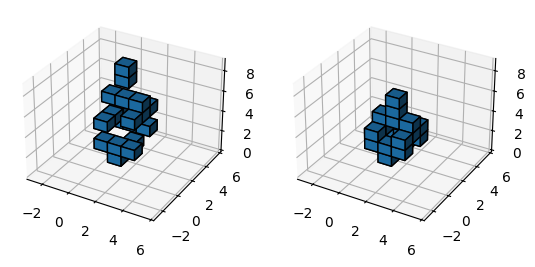

In [5]:
from matplotlib.pyplot import figure
from numpy import array

fig = figure()
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_xlim(-3, 6)
ax.set_ylim(-3, 6)
ax.set_zlim(0, 9)
ax.voxels(array(example_puzzle.voxels(4, 4, 10)), edgecolor="k")

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_xlim(-3, 6)
ax.set_ylim(-3, 6)
ax.set_zlim(0, 9)
ax.voxels(array(fallen_example_puzzle.voxels(4, 4, 10)), edgecolor="k")
None

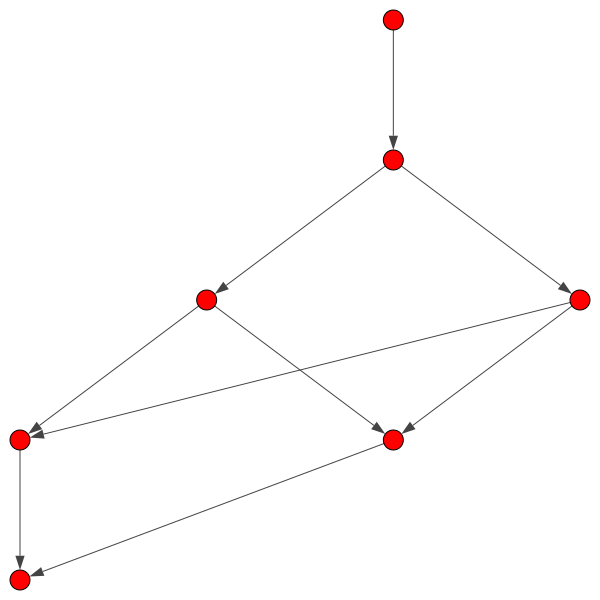

In [6]:
igraph.plot(fallen_example_puzzle.g, layout="tree")

In [7]:
data_puzzle = Puzzle.parse(data)
fallen_data_puzzle = data_puzzle.fall()
answer(fallen_data_puzzle.solve())

**Answer** = 428

## Part 2

In [8]:
fallen_example_puzzle.solve2()

7

In [9]:
answer(fallen_data_puzzle.solve2())

**Answer** = 35654